In [2]:
#package
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
using DataFrames
using CSV
using Base.Threads
using HDF5
gr()

Plots.GRBackend()

### フォワードモデル

In [3]:
#温度配列
function temp()
    Temp_table_chi= collect(0.2:0.2:70) # length 350
    return Temp_table_chi
end

#各種結晶場パラメータ
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1.0
    L = 3.0
    S = 0.5
    J = L - S
    g = 1.0 + (J * (J + 1.0) + S * (S + 1.0) - L * (L + 1.0)) / (2.0 * J * (J + 1.0))
    Jz = [2.5, 1.5, 0.5, -0.5, -1.5, -2.5]
    return J, g, Jz
end

#結晶場行列
function Onn_make(B40)
    # O40
    O40_vec_x = [60.0, -180.0, 120.0, 120.0, -180.0, 60.0]
    O40_vec = O40_vec_x * B40
    O40 = diagm(0 => O40_vec)
    Onn = O40
    # O44
    B44 = 5 * B40
    O44_value = sqrt(120.0 * 24.0) * B44 / 2.0
    Onn[5,1] = O44_value
    Onn[6,2] = O44_value
    Onn[1,5] = O44_value
    Onn[2,6] = O44_value
    return Onn
end

#磁化率生成関数
function chi(Onn)
    # 温度定義
    Temp_table_chi = temp()

    _, g, Jz = ini()
    magfield = 0.01
    #magdir = [0,0,1]
    #nor_magdir = [0,0,1]
    
    # 対角要素
    Hmag_vec_0 = Jz * magfield * g * 0.67171
    Hmag = diagm(0 => Hmag_vec_0)
    
    # 非対角要素はmagdir[x,y]が0なので0
    
    # 結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag
    
    eigval, eigvec = eigen(H)

    Temp_table_chi = temp()
    n_chi = 350
    chi_inv_Temp = zeros(n_chi)
    
    @inbounds for (i, Temp) in enumerate(Temp_table_chi)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)
        sumexp = sum(exp_eigval)

        mag_z = zeros(6)
        @simd for j in 1:6
            eigvec_check = eigvec[:,j]
            mag_z[j] = eigvec_check' * (eigvec_check .* Jz) * exp_eigval[j] / sumexp
        end

        Jmag_z = sum(mag_z) * g * (-1)
        Jmag = Jmag_z

        chi = Jmag / magfield * 0.5585
        chi_inv = 1.0 / chi
        chi_inv_Temp[i] = chi_inv
    end
    return chi_inv_Temp
end

function spc(Onn)
    #パラメータ読み込み
    _, g, _ = ini()

    # 非対角要素
    Hmag_vec_1 = sqrt.([5,8,9,8,5]) * (1 + 1*im) * 5 * g * 0.67171 / 2
    Hmag_1 = diagm(1 => Hmag_vec_1)
    Hmag_2 = diagm(-1 => conj.(Hmag_vec_1))
    Hmag = Hmag_1 + Hmag_2

    #結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    Temp_table_spc = temp()
    SpcHeat_Temp = zeros(length(Temp_table_spc))
    
    @inbounds for (i, Temp) in enumerate(Temp_table_spc)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)

        Z0 = sum(exp_eigval)
        Z1 = sum(eigval_2 .* exp_eigval)
        Z2 = sum(eigval_2.^2 .* exp_eigval)
        
        SpcHeat=(- (Z1/Z0)^2 + (Z2/Z0) )*8.31441
        SpcHeat_Temp[i] = SpcHeat
    end
    return SpcHeat_Temp
end

spc (generic function with 1 method)

### map解

In [4]:
map_chi = [
    0.1165828012219923,
    0.11675405201014133,
    0.11660652618938822,
]

3-element Vector{Float64}:
 0.1165828012219923
 0.11675405201014133
 0.11660652618938822

In [5]:
map_spc = [
    0.11684366002984604,
    0.11696818013197541,
    0.11835288280044565,
]

3-element Vector{Float64}:
 0.11684366002984604
 0.11696818013197541
 0.11835288280044565

In [6]:
map_int = [
    0.11679943741585459,
    0.11634975399320366,
    0.11784600489210055,
]

3-element Vector{Float64}:
 0.11679943741585459
 0.11634975399320366
 0.11784600489210055

### 読み込み関数

In [7]:
function read_file(file_path)
    file = h5open(file_path, "r")
    chi_Temp_inv = read(file, "chi_inv")
    return chi_Temp_inv
end

function read_file_spc(file_path)
    file = h5open(file_path, "r")
    data = read(file, "spc")
    return data
end

read_file_spc (generic function with 1 method)

### plot chi

In [4]:
# ノイズ入りデータ
chi_Temp_inv_noise = zeros(350,3)

for i in 1:3
    read_file_path = "/Users/nishimura/home/lab/data_make/data/chi_inv/chi_inv_" *string(i)* ".h5"
    #read_file_path = "/Users/test/home/lab_research_1/data_make/data/chi_inv/chi_inv_" *string(i)* ".h5"
    chi_Temp_inv_noise[:,i] = read_file(read_file_path)
end

In [9]:
# ノイズ入りデータ
SpcHeat_Temp_noise = zeros(350,3)

for i in 3:5
    read_file_path = "/Users/nishimura/home/lab/data_make/data/spc/spc_" *string(i)* ".h5"
    SpcHeat_Temp_noise[:,i-2] = read_file_spc(read_file_path)
end

#### no1

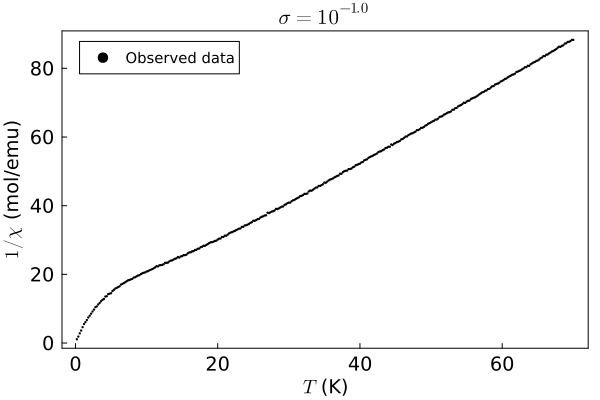

In [20]:
Temp_table_chi = collect(0.2:0.2:70)
plot(
        Temp_table_chi, chi_Temp_inv_noise[:,1],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$1/\chi$ (mol/emu)",
        label="Observed data",
        st=:scatter,
        markersize=1.3,
        framestyle = :box,
        title = L"\sigma=10^{-1.0}",
)

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [10]:
save_path_png = "/Users/nishimura/home/lab/data_make/visualize/chi_inv/chi_inv_1.png"
save_path_pdf = "/Users/nishimura/home/lab/data_make/visualize/chi_inv/chi_inv_1.pdf"
savefig(save_path_png)
savefig(save_path_pdf)

"/Users/nishimura/home/lab/data_make/visualize/chi_inv/chi_inv_1.pdf"

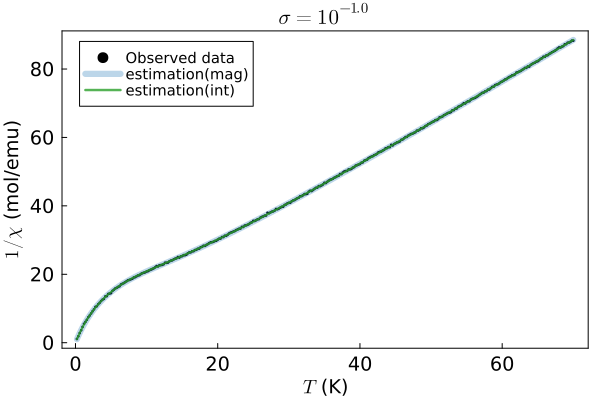

In [29]:
Temp_table_chi = collect(0.2:0.2:70)
plot(
        Temp_table_chi, chi_Temp_inv_noise[:,1],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$1/\chi$ (mol/emu)",
        label="Observed data",
        st=:scatter,
        markersize=1.5,
        framestyle = :box,
        title = L"\sigma=10^{-1.0}",
)

plot!(
        Temp_table_chi, chi(Onn_make(map_chi[1])),
        color=palette(:tab10)[1],
        label="estimation(mag)",
        linewidth = 6,
        alpha = 0.3,
)

plot!(
        Temp_table_chi, chi(Onn_make(map_int[1])),
        color=palette(:tab10)[3],
        label="estimation(int)",
        linewidth = 2,
        alpha = 0.8,
)

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [30]:
fitting_path = "/Users/nishimura/home/lab/exmc/fitting/visualize/chi1.pdf"
savefig(fitting_path)

"/Users/nishimura/home/lab/exmc/fitting/visualize/chi1.pdf"

#### no2

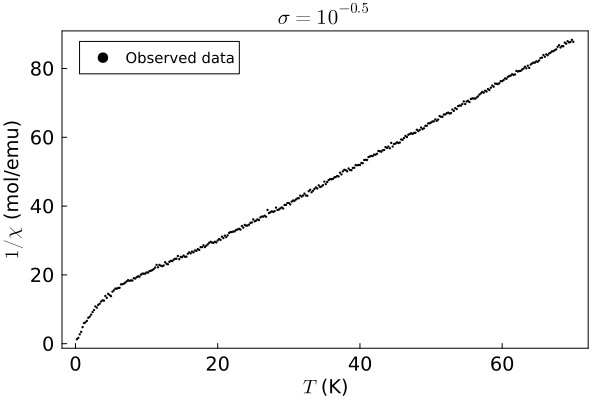

In [32]:
Temp_table_chi = collect(0.2:0.2:70)
plot(
        Temp_table_chi, chi_Temp_inv_noise[:,2],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$1/\chi$ (mol/emu)",
        label="Observed data",
        st=:scatter,
        markersize=1.3,
        framestyle = :box,
        title = L"\sigma=10^{-0.5}",
)

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [33]:
save_path_png = "/Users/nishimura/home/lab/data_make/visualize/chi_inv/chi_inv_2.png"
save_path_pdf = "/Users/nishimura/home/lab/data_make/visualize/chi_inv/chi_inv_2.pdf"
savefig(save_path_png)
savefig(save_path_pdf)

"/Users/nishimura/home/lab/data_make/visualize/chi_inv/chi_inv_2.pdf"

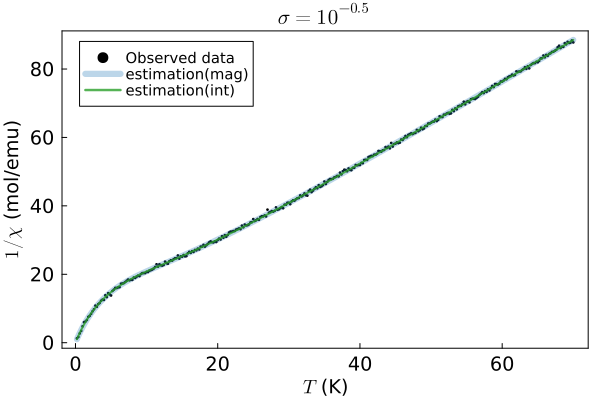

In [62]:
Temp_table_chi = collect(0.2:0.2:70)
plot(
        Temp_table_chi, chi_Temp_inv_noise[:,2],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$1/\chi$ (mol/emu)",
        label="Observed data",
        st=:scatter,
        markersize=1.5,
        framestyle = :box,
        title = L"\sigma=10^{-0.5}",
)

plot!(
        Temp_table_chi, chi(Onn_make(map_chi[2])),
        color=palette(:tab10)[1],
        label="estimation(mag)",
        linewidth = 6,
        alpha = 0.3,
)

plot!(
        Temp_table_chi, chi(Onn_make(map_int[2])),
        color=palette(:tab10)[3],
        label="estimation(int)",
        linewidth = 2,
        alpha = 0.8,
)

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [63]:
fitting_path = "/Users/nishimura/home/lab/exmc/fitting/visualize/chi2.pdf"
savefig(fitting_path)

"/Users/nishimura/home/lab/exmc/fitting/visualize/chi2.pdf"

#### no3

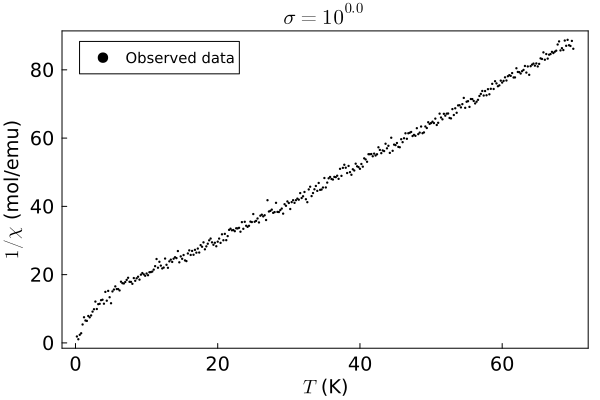

In [37]:
Temp_table_chi = collect(0.2:0.2:70)
plot(
        Temp_table_chi, chi_Temp_inv_noise[:,3],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$1/\chi$ (mol/emu)",
        label="Observed data",
        st=:scatter,
        markersize=1.3,
        framestyle = :box,
        title = L"\sigma=10^{0.0}",
)

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [38]:
save_path_png = "/Users/nishimura/home/lab/data_make/visualize/chi_inv/chi_inv_3.png"
save_path_pdf = "/Users/nishimura/home/lab/data_make/visualize/chi_inv/chi_inv_3.pdf"
savefig(save_path_png)
savefig(save_path_pdf)

"/Users/nishimura/home/lab/data_make/visualize/chi_inv/chi_inv_3.pdf"

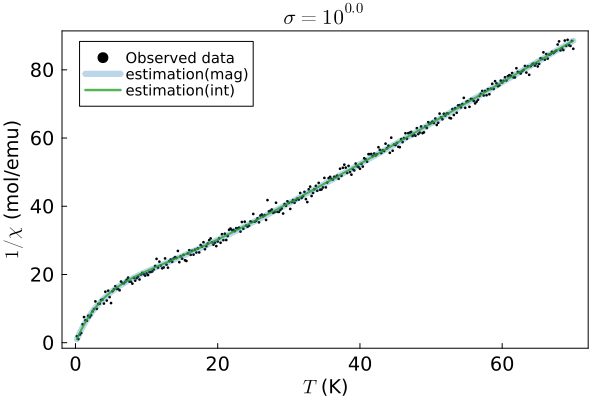

In [64]:
Temp_table_chi = collect(0.2:0.2:70)
plot(
        Temp_table_chi, chi_Temp_inv_noise[:,3],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$1/\chi$ (mol/emu)",
        label="Observed data",
        st=:scatter,
        markersize=1.5,
        framestyle = :box,
        title = L"\sigma=10^{0.0}",
)

plot!(
        Temp_table_chi, chi(Onn_make(map_chi[3])),
        color=palette(:tab10)[1],
        label="estimation(mag)",
        linewidth = 6,
        alpha = 0.3,
)

plot!(
        Temp_table_chi, chi(Onn_make(map_int[3])),
        color=palette(:tab10)[3],
        label="estimation(int)",
        linewidth = 2,
        alpha = 0.8,
)

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [65]:
fitting_path = "/Users/nishimura/home/lab/exmc/fitting/visualize/chi3.pdf"
savefig(fitting_path)

"/Users/nishimura/home/lab/exmc/fitting/visualize/chi3.pdf"

### plot spc

#### no1

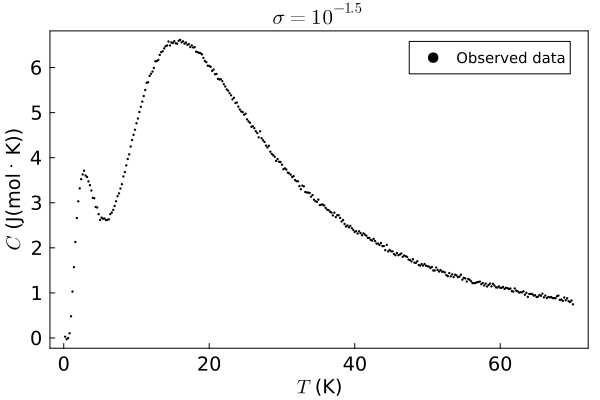

In [19]:
Temp_table_spc = collect(0.2:0.2:70)

plot(
        Temp_table_spc, SpcHeat_Temp_noise[:,1],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$C$ (J(mol $\cdot$ K))",
        label="Observed data",
        st=:scatter,
        markersize=1.3,
        framestyle = :box,
        title = L"\sigma=10^{-1.5}",
    )

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [61]:
save_path_png = "/Users/nishimura/home/lab/data_make/visualize/spc/spc_3.png"
save_path_pdf = "/Users/nishimura/home/lab/data_make/visualize/spc/spc_3.pdf"
savefig(save_path_png)
savefig(save_path_pdf)

"/Users/nishimura/home/lab/data_make/visualize/spc/spc_3.pdf"

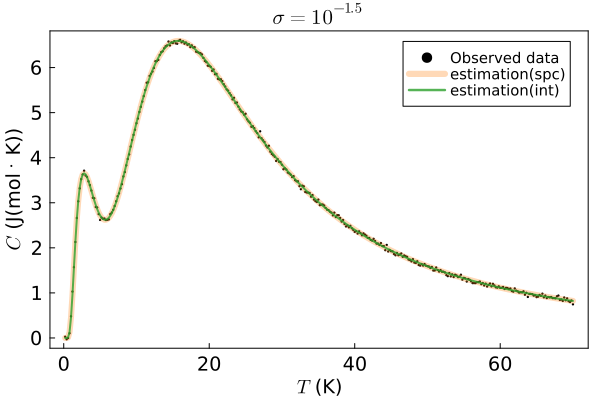

In [68]:
Temp_table_spc = collect(0.2:0.2:70)

plot(
        Temp_table_spc, SpcHeat_Temp_noise[:,1],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$C$ (J(mol $\cdot$ K))",
        label="Observed data",
        st=:scatter,
        markersize=1.3,
        framestyle = :box,
        title = L"\sigma=10^{-1.5}",
)

plot!(
        Temp_table_spc, spc(Onn_make(map_spc[1])),
        color=palette(:tab10)[2],
        label="estimation(spc)",
        linewidth = 6,
        alpha = 0.3,
)

plot!(
        Temp_table_spc, spc(Onn_make(map_int[1])),
        color=palette(:tab10)[3],
        label="estimation(int)",
        linewidth = 2,
        alpha = 0.8,
)

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [69]:
fitting_path = "/Users/nishimura/home/lab/exmc/fitting/visualize/spc3.pdf"
savefig(fitting_path)

"/Users/nishimura/home/lab/exmc/fitting/visualize/spc3.pdf"

#### no2

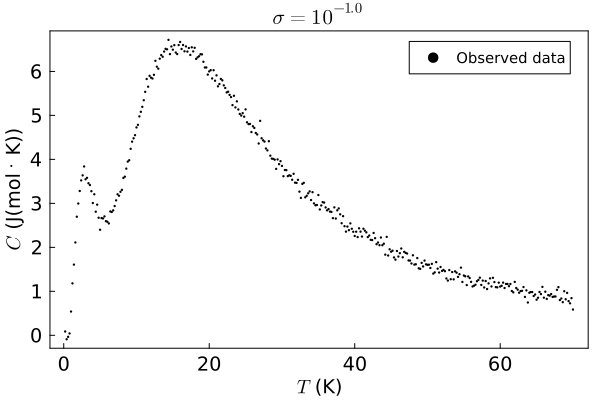

In [70]:
Temp_table_spc = collect(0.2:0.2:70)

plot(
        Temp_table_spc, SpcHeat_Temp_noise[:,2],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$C$ (J(mol $\cdot$ K))",
        label="Observed data",
        st=:scatter,
        markersize=1.3,
        framestyle = :box,
        title = L"\sigma=10^{-1.0}",
    )

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [71]:
save_path_png = "/Users/nishimura/home/lab/data_make/visualize/spc/spc_4.png"
save_path_pdf = "/Users/nishimura/home/lab/data_make/visualize/spc/spc_4.pdf"
savefig(save_path_png)
savefig(save_path_pdf)

"/Users/nishimura/home/lab/data_make/visualize/spc/spc_4.pdf"

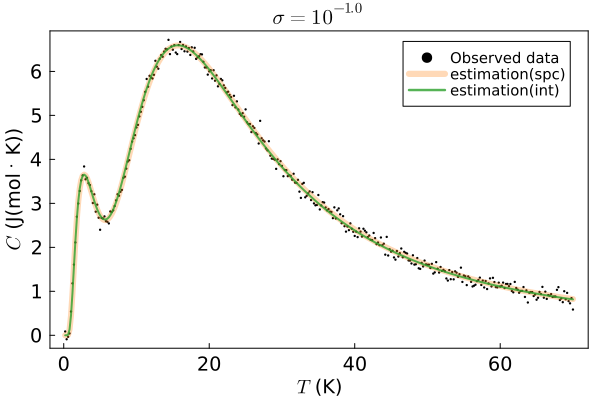

In [11]:
Temp_table_spc = collect(0.2:0.2:70)

plot(
        Temp_table_spc, SpcHeat_Temp_noise[:,2],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$C$ (J(mol $\cdot$ K))",
        label="Observed data",
        st=:scatter,
        markersize=1.3,
        framestyle = :box,
        title = L"\sigma=10^{-1.0}",
)

plot!(
        Temp_table_spc, spc(Onn_make(map_spc[2])),
        color=palette(:tab10)[2],
        label="estimation(spc)",
        linewidth = 6,
        alpha = 0.3,
)

plot!(
        Temp_table_spc, spc(Onn_make(map_int[2])),
        color=palette(:tab10)[3],
        label="estimation(int)",
        linewidth = 2,
        alpha = 0.8,
)

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [12]:
fitting_path = "/Users/nishimura/home/lab/exmc/fitting/visualize/spc4.pdf"
savefig(fitting_path)

"/Users/nishimura/home/lab/exmc/fitting/visualize/spc4.pdf"

#### no3

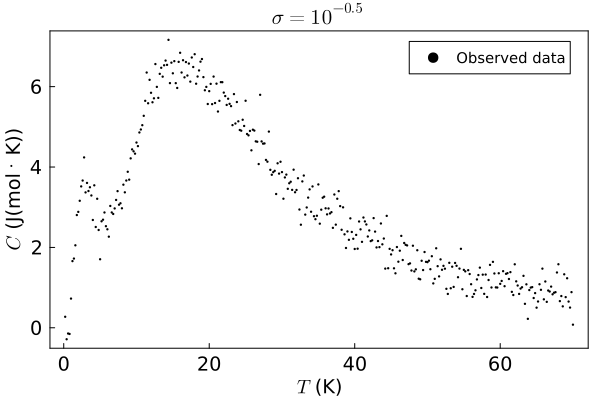

In [13]:
Temp_table_spc = collect(0.2:0.2:70)

plot(
        Temp_table_spc, SpcHeat_Temp_noise[:,3],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$C$ (J(mol $\cdot$ K))",
        label="Observed data",
        st=:scatter,
        markersize=1.3,
        framestyle = :box,
        title = L"\sigma=10^{-0.5}",
    )

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [14]:
save_path_png = "/Users/nishimura/home/lab/data_make/visualize/spc/spc_5.png"
save_path_pdf = "/Users/nishimura/home/lab/data_make/visualize/spc/spc_5.pdf"
savefig(save_path_png)
savefig(save_path_pdf)

"/Users/nishimura/home/lab/data_make/visualize/spc/spc_5.pdf"

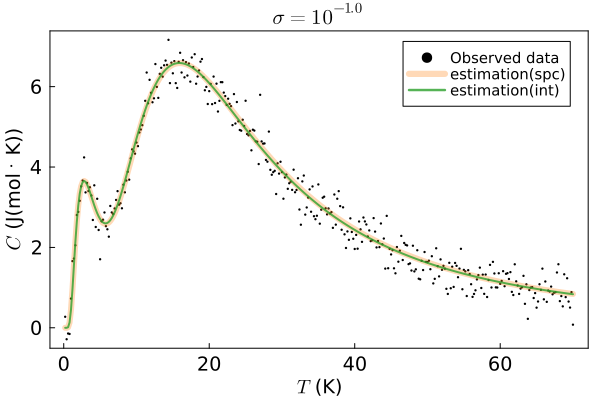

In [15]:
Temp_table_spc = collect(0.2:0.2:70)

plot(
        Temp_table_spc, SpcHeat_Temp_noise[:,3],
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$C$ (J(mol $\cdot$ K))",
        label="Observed data",
        st=:scatter,
        markersize=1.3,
        framestyle = :box,
        title = L"\sigma=10^{-1.0}",
)

plot!(
        Temp_table_spc, spc(Onn_make(map_spc[3])),
        color=palette(:tab10)[2],
        label="estimation(spc)",
        linewidth = 6,
        alpha = 0.3,
)

plot!(
        Temp_table_spc, spc(Onn_make(map_int[3])),
        color=palette(:tab10)[3],
        label="estimation(int)",
        linewidth = 2,
        alpha = 0.8,
)

plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [16]:
fitting_path = "/Users/nishimura/home/lab/exmc/fitting/visualize/spc5.pdf"
savefig(fitting_path)

"/Users/nishimura/home/lab/exmc/fitting/visualize/spc5.pdf"

### ノイズが大きい場合

In [18]:
# ノイズ入りデータ
read_file_path = "/Users/nishimura/home/lab/data_make/data/chi_inv/chi_inv_5.h5"
chi_Temp_inv_noise_5 = read_file(read_file_path);

In [21]:
map_chi_5 = 0.12063821348416197

0.12063821348416197

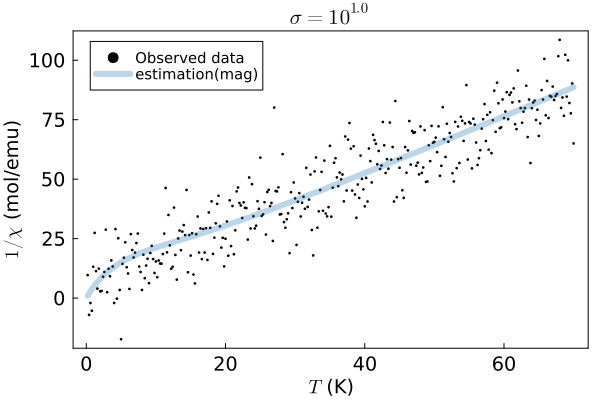

In [22]:
Temp_table_chi = collect(0.2:0.2:70)
plot(
        Temp_table_chi, chi_Temp_inv_noise_5,
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$1/\chi$ (mol/emu)",
        label="Observed data",
        st=:scatter,
        markersize=1.5,
        framestyle = :box,
        title = L"\sigma=10^{1.0}",
)

plot!(
        Temp_table_chi, chi(Onn_make(map_chi_5)),
        color=palette(:tab10)[1],
        label="estimation(mag)",
        linewidth = 6,
        alpha = 0.3,
)


plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)

In [24]:
# ノイズ入りデータ
read_file_path = "/Users/nishimura/home/lab/data_make/data/spc/spc_7.h5"
SpcHeat_Temp_noise_7 = read_file_spc(read_file_path);

In [25]:
map_spc_7 = 0.13080957371811158

0.13080957371811158

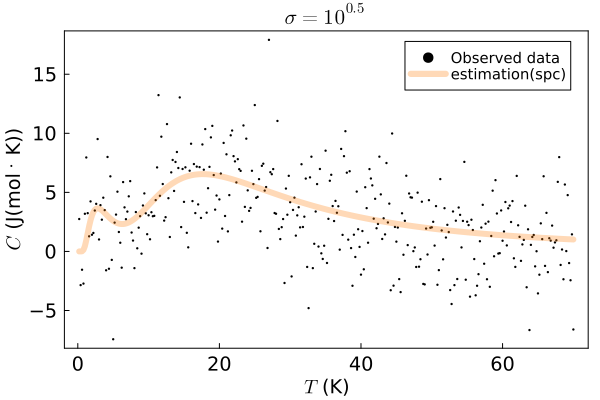

In [26]:
Temp_table_spc = collect(0.2:0.2:70)

plot(
        Temp_table_spc, SpcHeat_Temp_noise_7,
        color="black",
        xlabel=L"$T$ (K)",
        ylabel=L"$C$ (J(mol $\cdot$ K))",
        label="Observed data",
        st=:scatter,
        markersize=1.3,
        framestyle = :box,
        title = L"\sigma=10^{0.5}",
)

plot!(
        Temp_table_spc, spc(Onn_make(map_spc_7)),
        color=palette(:tab10)[2],
        label="estimation(spc)",
        linewidth = 6,
        alpha = 0.3,
)


plot!(
    grid = false,
    xtickfont = font(13),
    ytickfont = font(13),
    guidefont = font(13),
    legendfont = font(10),
)